In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import importlib
import sys
from pathlib import Path
import pickle

# Add parent directory to path
sys.path.insert(0, str(Path.cwd().parent))

import src.holt_winters
importlib.reload(src.holt_winters)
from src.holt_winters import create_holt_winters_model

In [3]:
# Load dataset
df = pd.read_csv("datasets/nasa_requests_per_minute.csv")
df["time"] = pd.to_datetime(df["time"])
df = df.set_index("time")

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nFirst few rows:\n{df.head()}")

Dataset shape: (87015, 1)
Date range: 1995-07-01 00:00:00 to 1995-08-31 23:59:00

First few rows:
                     number_of_requests
time                                   
1995-07-01 00:00:00                  42
1995-07-01 00:01:00                  61
1995-07-01 00:02:00                  57
1995-07-01 00:03:00                  71
1995-07-01 00:04:00                  70


In [4]:
# Split into train (90%) and test (10%) sets
train_size = int(len(df) * 0.9)

train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

print(f"Training set: {len(train_data)} observations")
print(f"Test set: {len(test_data)} observations")
print(f"\nTrain period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Test period: {test_data.index.min()} to {test_data.index.max()}")

Training set: 78313 observations
Test set: 8702 observations

Train period: 1995-07-01 00:00:00 to 1995-08-25 22:57:00
Test period: 1995-08-25 22:58:00 to 1995-08-31 23:59:00


In [12]:
# Create and train the model
# seasonal_periods=1440 means daily seasonality (1440 minutes in a day)
model = create_holt_winters_model(seasonal_periods=1440)

print("Training model on training data...")
model.fit(train_data['number_of_requests'].tolist())
print("Model training complete!")
print(f"Model fitted: {model.is_fitted()}")

Training model on training data...


C:\Users\ajaylk\uni\fyp\code\tsf-models\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Model training complete!
Model fitted: True


In [17]:
import importlib
importlib.reload(src.holt_winters)
from src.holt_winters import create_holt_winters_model

In [18]:
# Test with online learning: predict then update
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

predictions = []
actuals = []
prediction_intervals = []

print("Running online learning on test set...")
print("(Predict -> Evaluate -> Update with actual value -> Repeat)\n")

for i in range(len(test_data)):
    # 1. Make prediction for next time step
    pred_dict = model.predict(steps=1)
    
    # 2. Get actual value
    actual_value = test_data.iloc[i]['number_of_requests']
    
    # 3. Store results
    predictions.append(pred_dict['mean'])
    actuals.append(actual_value)
    prediction_intervals.append({
        'lower': pred_dict['lower_bound'],
        'upper': pred_dict['upper_bound'],
        'std': pred_dict['std']
    })
    
    # 4. Update model with actual value for next prediction
    model.update([actual_value])
    
    # Print progress every 1000 steps
    if (i + 1) % 1000 == 0:
        print(f"Processed {i + 1}/{len(test_data)} test samples")

print("\nOnline learning complete!")

Running online learning on test set...
(Predict -> Evaluate -> Update with actual value -> Repeat)

Processed 1000/8702 test samples


KeyboardInterrupt: 

In [14]:
# Calculate evaluation metrics
predictions = np.array(predictions)
actuals = np.array(actuals)

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
mape = mean_absolute_percentage_error(actuals, predictions) * 100

# Calculate coverage (% of actuals within prediction intervals)
within_interval = sum(
    1 for i, actual in enumerate(actuals)
    if prediction_intervals[i]['lower'] <= actual <= prediction_intervals[i]['upper']
)
coverage = (within_interval / len(actuals)) * 100

print("="*60)
print("MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Mean Absolute Error (MAE):           {mae:.2f} requests")
print(f"Root Mean Squared Error (RMSE):      {rmse:.2f} requests")
print(f"Mean Absolute Percentage Error:      {mape:.2f}%")
print(f"Prediction Interval Coverage (95%):  {coverage:.2f}%")
print("="*60)

# Summary statistics
print(f"\nActual values - Mean: {actuals.mean():.2f}, Std: {actuals.std():.2f}")
print(f"Predicted values - Mean: {predictions.mean():.2f}, Std: {predictions.std():.2f}")

MODEL PERFORMANCE METRICS
Mean Absolute Error (MAE):           10.88 requests
Root Mean Squared Error (RMSE):      14.49 requests
Mean Absolute Percentage Error:      13473736630013778.00%
Prediction Interval Coverage (95%):  92.88%

Actual values - Mean: 41.44, Std: 28.37
Predicted values - Mean: 41.49, Std: 25.99


In [16]:
# Display side-by-side comparison
import pandas as pd

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Timestamp': test_data.index,
    'Actual': actuals,
    'Predicted': [round(p, 2) for p in predictions],
    'Error': [round(a - p, 2) for a, p in zip(actuals, predictions)],
    'Abs_Error': [round(abs(a - p), 2) for a, p in zip(actuals, predictions)],
    'Lower_95%': [round(pi['lower'], 2) for pi in prediction_intervals],
    'Upper_95%': [round(pi['upper'], 2) for pi in prediction_intervals]
})

print("\n" + "="*100)
print("PREDICTION vs ACTUAL COMPARISON (First 50 samples)")
print("="*100)
print(comparison_df.head(50).to_string(index=False))

print("\n" + "="*100)
print("PREDICTION vs ACTUAL COMPARISON (Last 50 samples)")
print("="*100)
print(comparison_df.tail(50).to_string(index=False))

# Show some interesting cases
print("\n" + "="*100)
print("LARGEST PREDICTION ERRORS (Top 20)")
print("="*100)
largest_errors = comparison_df.nlargest(20, 'Abs_Error')
print(largest_errors.to_string(index=False))

print("\n" + "="*100)
print("BEST PREDICTIONS (Top 20 - Smallest Errors)")
print("="*100)
best_predictions = comparison_df.nsmallest(20, 'Abs_Error')
print(best_predictions.to_string(index=False))


PREDICTION vs ACTUAL COMPARISON (First 50 samples)
          Timestamp  Actual  Predicted  Error  Abs_Error  Lower_95%  Upper_95%
1995-08-25 22:58:00      27      23.23   3.77       3.77      -5.39      51.84
1995-08-25 22:59:00      25      27.30  -2.30       2.30       0.70      53.90
1995-08-25 23:00:00      21      18.15   2.85       2.85      -8.45      44.75
1995-08-25 23:01:00      14      22.03  -8.03       8.03      -4.57      48.63
1995-08-25 23:02:00      27      15.59  11.41      11.41     -11.01      42.18
1995-08-25 23:03:00      33      20.15  12.85      12.85      -6.45      46.75
1995-08-25 23:04:00      33      23.46   9.54       9.54      -3.13      50.06
1995-08-25 23:05:00      49      24.01  24.99      24.99      -2.59      50.61
1995-08-25 23:06:00      23      34.35 -11.35      11.35       7.76      60.95
1995-08-25 23:07:00      32      31.78   0.22       0.22       5.18      58.38
1995-08-25 23:08:00      42      30.94  11.06      11.06       4.34      57.54


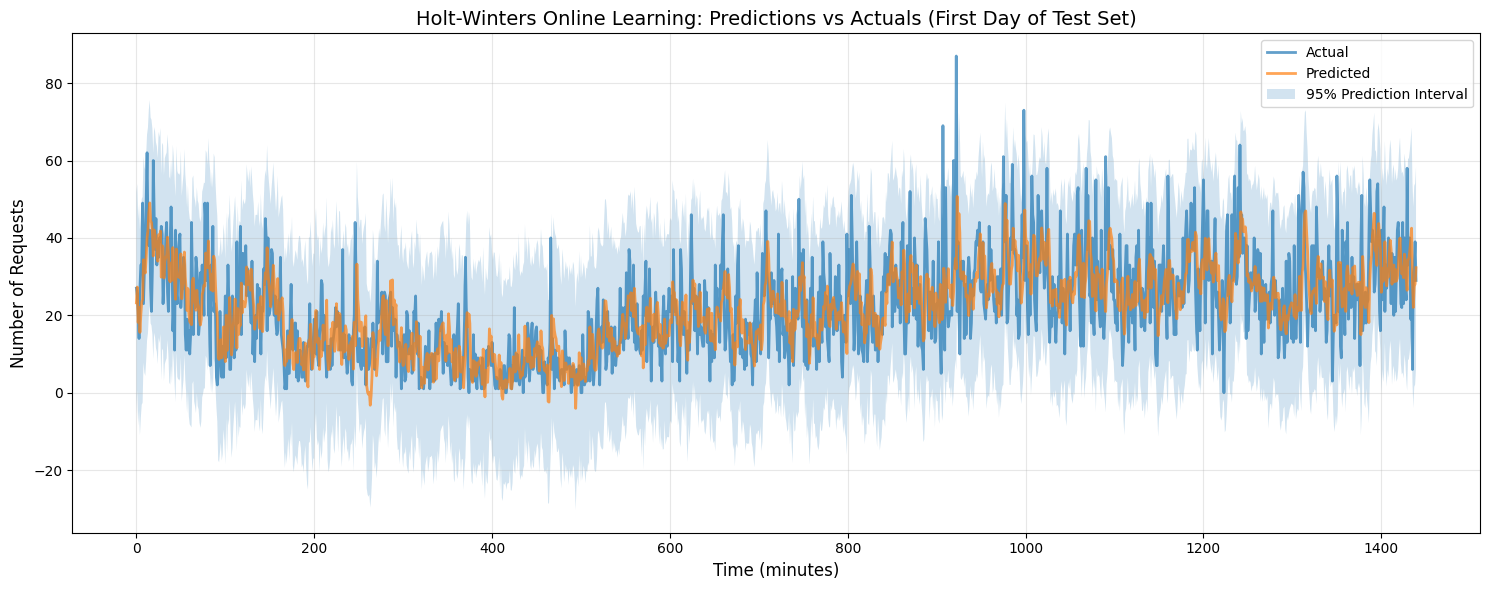

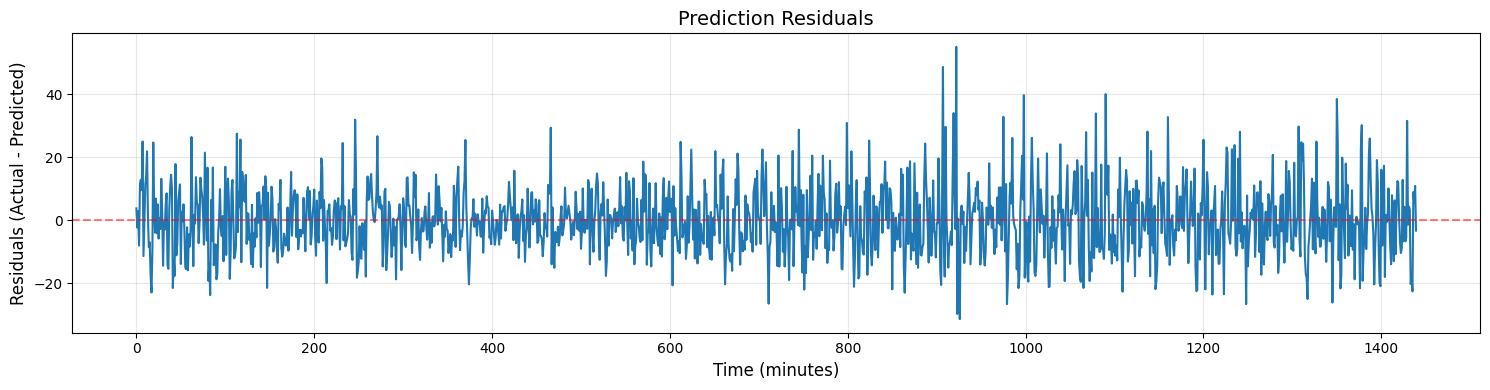

In [15]:
# Visualize results
import matplotlib.pyplot as plt

# Plot a subset for clarity (first 1440 minutes = 1 day)
plot_samples = min(1440, len(test_data))

plt.figure(figsize=(15, 6))
plt.plot(range(plot_samples), actuals[:plot_samples], label='Actual', linewidth=2, alpha=0.7)
plt.plot(range(plot_samples), predictions[:plot_samples], label='Predicted', linewidth=2, alpha=0.7)

# Plot prediction intervals
lower_bounds = [pi['lower'] for pi in prediction_intervals[:plot_samples]]
upper_bounds = [pi['upper'] for pi in prediction_intervals[:plot_samples]]
plt.fill_between(range(plot_samples), lower_bounds, upper_bounds, alpha=0.2, label='95% Prediction Interval')

plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.title('Holt-Winters Online Learning: Predictions vs Actuals (First Day of Test Set)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = actuals[:plot_samples] - predictions[:plot_samples]
plt.figure(figsize=(15, 4))
plt.plot(range(plot_samples), residuals)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.title('Prediction Residuals', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Save the trained model
model_path = '../../models/holt_winters_online.pkl'

# Create models directory if it doesn't exist
Path(model_path).parent.mkdir(parents=True, exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

print(f"Model saved to: {model_path}")
print(f"Model includes all training data + test data from online learning")

In [ ]:
# Test loading the model
with open(model_path, 'rb') as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")
print(f"Model is fitted: {loaded_model.is_fitted()}")
print(f"Model has {len(loaded_model.data)} data points")

# Test prediction
test_pred = loaded_model.predict(steps=1)
print(f"\nTest prediction: {test_pred['mean']:.2f} requests")
print(f"95% interval: [{test_pred['lower_bound']:.2f}, {test_pred['upper_bound']:.2f}]")